## Tanzania Tourism Prediction

The Tanzanian tourism sector plays a significant role in the Tanzanian economy, contributing about 17% to the country’s GDP and 25% of all foreign exchange revenues. The sector, which provides direct employment for more than 600,000 people and up to 2 million people indirectly, generated approximately $2.4 billion in 2018 according to government statistics. Tanzania received a record 1.1 million international visitor arrivals in 2014, mostly from Europe, the US and Africa.
</br>
</br>
The objective of this notebook is to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import zscore


import warnings
warnings.filterwarnings('ignore')

# set the max columns to none
pd.set_option('display.max_columns', None)

# set printoptions not to display numbers in scientific notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# set dark background for plots to be better seen in VSCode dark mode
from matplotlib import style
style.use('dark_background')


In [2]:
# Import tanzania tourism data
raw_data_df = pd.read_csv('data/Train.csv')

TZS_RATE = 2628.57

## Split features X and target y

In [3]:
X = raw_data_df.drop("total_cost", axis=1)
y = raw_data_df["total_cost"]

## Splitting data for testing 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape
X_test.shape

(962, 22)

In [5]:
# Concatenate train features and target value for EDA
tourism_df = pd.concat([X_train,y_train], axis=1)

## First overview of the train data

In [6]:
tourism_df.head(10)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
402,tour_1491,UNITED STATES OF AMERICA,45-64,Friends/Relatives,10.000,2.000,Visiting Friends and Relatives,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,No,Yes,Yes,No,21.000,0.000,Cash,Yes,Wildlife,9116250.000
4543,tour_675,UNITED KINGDOM,1-24,Friends/Relatives,1.000,1.000,Leisure and Holidays,Conference tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,6.000,7.000,Cash,Yes,Wildlife,7112625.000
3541,tour_529,UNITED KINGDOM,1-24,NaN,1.000,0.000,Volunteering,Wildlife tourism,"Friends, relatives",Package Tour,No,Yes,Yes,Yes,Yes,No,No,26.000,2.000,Cash,Yes,No comments,8250645.000
2377,tour_3894,ZIMBABWE,25-44,Alone,0.000,1.000,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,7.000,0.000,Cash,No,NaN,828750.000
4584,tour_724,UNITED KINGDOM,25-44,Spouse,1.000,1.000,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,6.000,0.000,Cash,No,Friendly People,3107600.000
1777,tour_3166,ITALY,25-44,Friends/Relatives,2.000,2.000,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,No,No,Yes,No,7.000,7.000,Cash,Yes,"Wonderful Country, Landscape, Nature",20553000.000
4678,tour_833,CHINA,45-64,Friends/Relatives,1.000,5.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,No,No,No,No,No,10.000,0.000,Cash,Yes,No comments,8619000.000
4292,tour_6196,ZAMBIA,25-44,NaN,1.000,0.000,Business,Wildlife tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,5.000,0.000,Cash,No,NaN,1657500.000
650,tour_18,UNITED STATES OF AMERICA,1-24,NaN,1.000,0.000,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,69.000,0.000,Cash,Yes,"Wonderful Country, Landscape, Nature",4060875.000
4275,tour_6179,ZIMBABWE,25-44,Friends/Relatives,0.000,2.000,Business,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,2.000,0.000,Cash,No,Wildlife,828750.000


In [7]:
tourism_df.shape

(3847, 23)

In [8]:
tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3847 entries, 402 to 860
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     3847 non-null   object 
 1   country                3847 non-null   object 
 2   age_group              3847 non-null   object 
 3   travel_with            2956 non-null   object 
 4   total_female           3845 non-null   float64
 5   total_male             3842 non-null   float64
 6   purpose                3847 non-null   object 
 7   main_activity          3847 non-null   object 
 8   info_source            3847 non-null   object 
 9   tour_arrangement       3847 non-null   object 
 10  package_transport_int  3847 non-null   object 
 11  package_accomodation   3847 non-null   object 
 12  package_food           3847 non-null   object 
 13  package_transport_tz   3847 non-null   object 
 14  package_sightseeing    3847 non-null   object 
 15  pac

There are NaNs in the columns travel_with, total_female, total_male, and most_impressing.
Most features are categorical.

In [9]:
tourism_df.describe()

,total_female,total_male,night_mainland,night_zanzibar,total_cost
count,3845.000,3842.000,3847.000,3847.000,3847.000
mean,0.944,1.009,8.399,2.337,8197220.085
std,1.342,1.168,10.060,4.246,12307605.155
min,0.000,0.000,0.000,0.000,49000.000
25%,0.000,1.000,3.000,0.000,828750.000
50%,1.000,1.000,6.000,0.000,3397875.000
75%,1.000,1.000,11.000,4.000,9945000.000
max,49.000,44.000,120.000,60.000,99532875.000


In [10]:
y_train.std()

12307605.15481707

## Quick overview of the distribution of the target value

In [11]:
# Create bins for target total_cost
total_cost_bins = np.arange(tourism_df.total_cost.min(), tourism_df.total_cost.max(), 1000000)
total_cost_bins_series = pd.cut(tourism_df.total_cost, bins=total_cost_bins, labels=total_cost_bins[:-1])	
total_cost_bins_series.name = 'total_cost_bins'

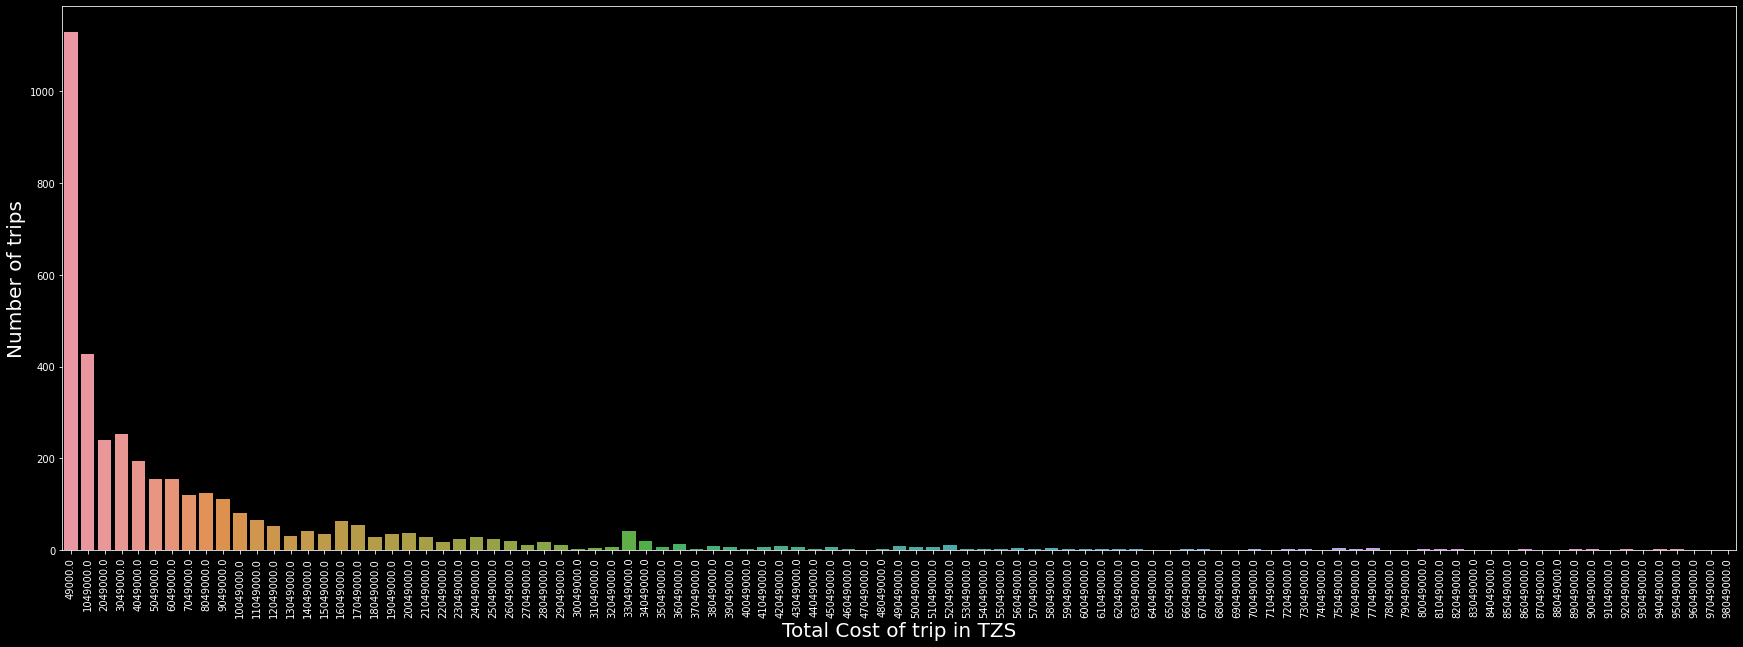

In [12]:
# plot the target value distribution
fig, axes = plt.subplots(1,1, figsize=(30, 10))
axes.tick_params(axis='x', rotation=90)
fig = sns.countplot(x=total_cost_bins_series)

fig.set_ylabel("Number of trips", fontsize = 20)
fig.set_xlabel("Total Cost of trip in TZS", fontsize = 20)

plt.savefig('images/total_cost_distribution.png')
plt.show()

The distribution of the target value for total cost of a trip is right skewed. Log transformation will be used on the target data to overcome this issue.

## Further examination of features and their influence on the total cost of a trip

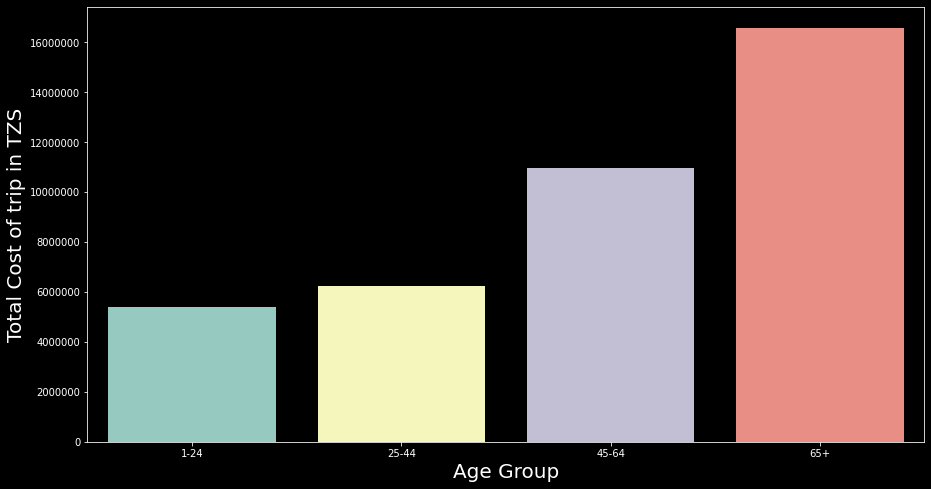

In [13]:
# Relation of total cost to age_group
age_group_df = tourism_df.groupby(['age_group']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(15, 8))
fig = sns.barplot(x='age_group', y='total_cost', data=age_group_df)
plt.ticklabel_format(style='plain', axis='y')
fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Age Group", fontsize = 20)

plt.savefig('images/age_group_total_cost.png')
plt.show()

The higher the age, the higher the total cost of the trip.

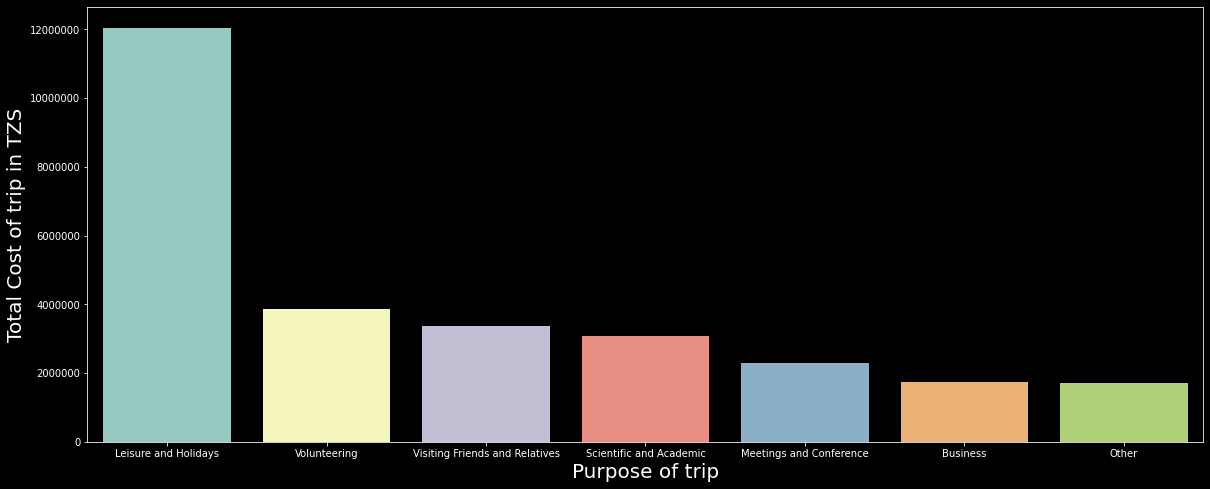

In [14]:
# Relation of total cost to purpose
purpose_df = tourism_df.groupby(['purpose']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(20, 8))
fig = sns.barplot(x='purpose', y='total_cost', data=purpose_df, order = purpose_df.sort_values('total_cost', ascending = False).purpose)
plt.ticklabel_format(style='plain', axis='y')
#axes.tick_params(axis='x', rotation=60)

fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Purpose of trip", fontsize = 20)


plt.savefig('images/purpose_total_cost.png')
plt.show()

People travelling for the purpose of Leisure and Holidays spend significantly more money than people travelling for other reasons.

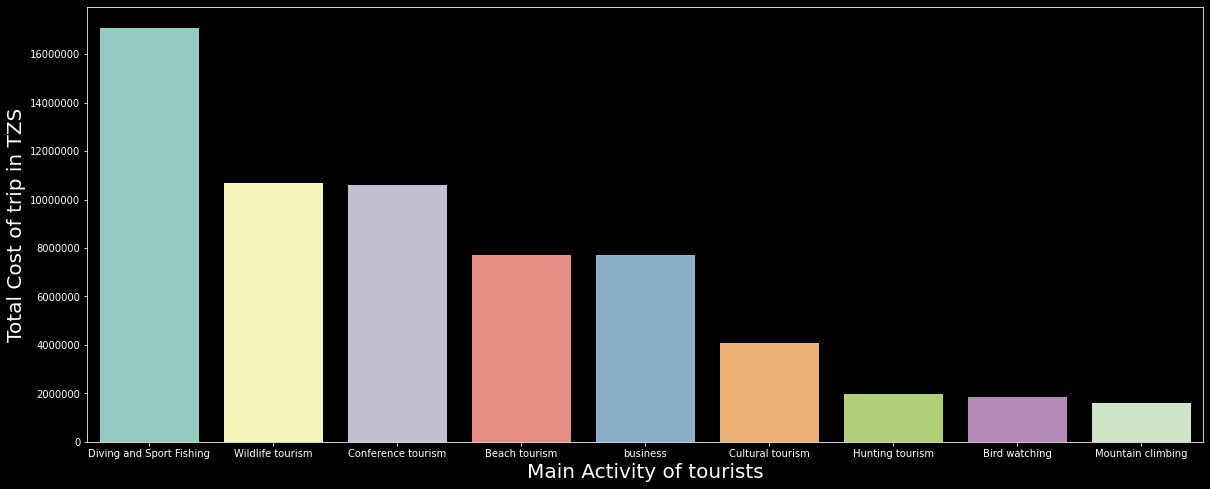

In [15]:
# Relation of total cost to main_activity
main_activity_df = tourism_df.groupby(['main_activity']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(20, 8))
fig = sns.barplot(x='main_activity', y='total_cost', data=main_activity_df, order = main_activity_df.sort_values('total_cost', ascending = False).main_activity)
plt.ticklabel_format(style='plain', axis='y')
#axes.tick_params(axis='x', rotation=60)

fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Main Activity of tourists", fontsize = 20)


plt.savefig('images/main_activity_total_cost.png')
plt.show()

Total cost depends on main activity of the trip. The most money is spent when main activities are Diving and Sport Fishing, least for Hunting tourism and Mountain climbing.

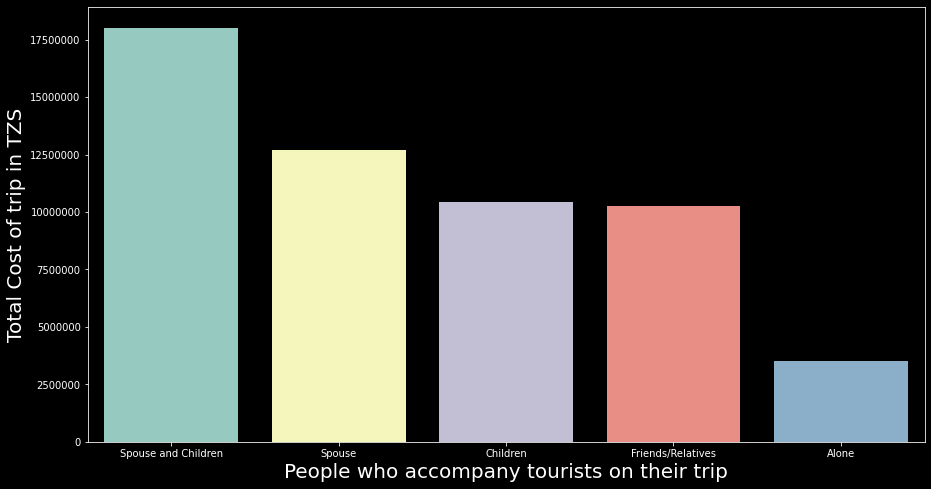

In [16]:
# Relation of total cost to travel_with
travel_with_df = tourism_df.groupby(['travel_with']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(15, 8))
fig = sns.barplot(x='travel_with', y='total_cost', data=travel_with_df, order = travel_with_df.sort_values('total_cost', ascending = False).travel_with)
plt.ticklabel_format(style='plain', axis='y')
#axes.tick_params(axis='x', rotation=60)

fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("People who accompany tourists on their trip", fontsize = 20)


plt.savefig('images/travel_with_total_cost.png')
plt.show()

Total cost depends on who is travelled with. The most money is spent when travelling with spouse and Children.

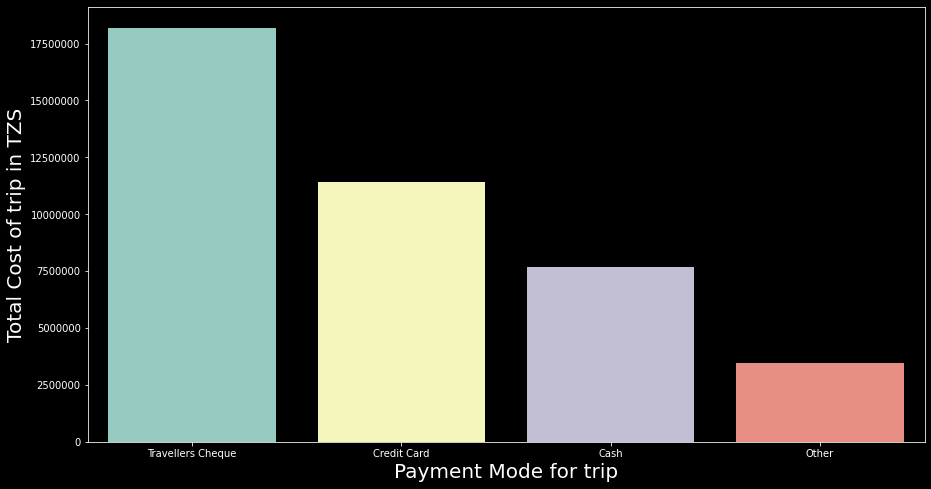

In [17]:
# Relation of total cost to payment_mode
payment_mode_df = tourism_df.groupby(['payment_mode']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(15, 8))
fig = sns.barplot(x='payment_mode', y='total_cost', data=payment_mode_df, order = payment_mode_df.sort_values('total_cost', ascending = False).payment_mode)
plt.ticklabel_format(style='plain', axis='y')

fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Payment Mode for trip", fontsize = 20)


plt.savefig('images/payment_mode_total_cost.png')
plt.show()

There are differences among the 4 groups of payment methods in amount of total cost. People paying with Traveller Cheques seem to spend the most money.

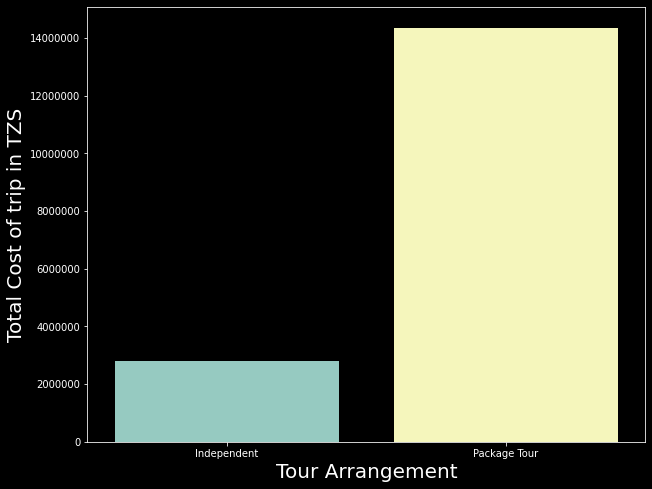

In [18]:
# Relation of total cost to tour_arrangement
tour_arrangement_df = tourism_df.groupby(['tour_arrangement']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(10, 8))
fig = sns.barplot(x='tour_arrangement', y='total_cost', data=tour_arrangement_df)

plt.ticklabel_format(style='plain', axis='y')
fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Tour Arrangement", fontsize = 20)


plt.savefig('images/tour_arrangement_total_cost.png')
plt.show()

Significantly more money is spent when travelling with a Package Tour than when travelling Independent.

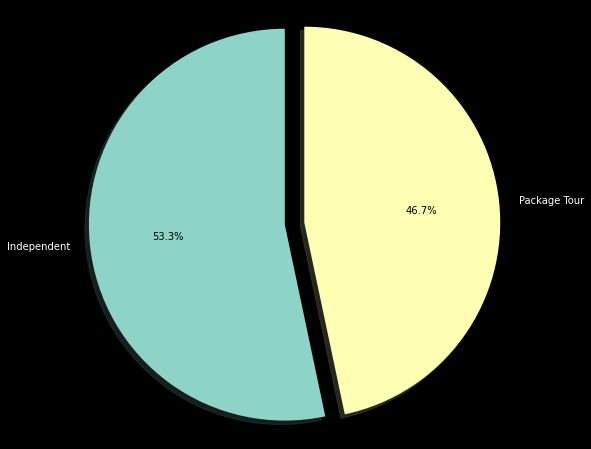

In [19]:
# Distribution of Tour arrangements

tour_arrangement_count = tourism_df['tour_arrangement'].value_counts()
tour_arrangement_count = tour_arrangement_count.reset_index()


labels = list(tour_arrangement_count['index'])
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(1,1, figsize=(10, 8))
patches, texts, autotexts  = ax.pie(tour_arrangement_count['tour_arrangement'], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'color':"black"})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
[text.set_color('white') for text in texts]
[autotext.set_color('black') for autotext in autotexts]

plt.savefig('images/tour_arrangement_percentage.png')
plt.show()

Distribution between Independant travelling and Package Tour is almost equal, less Package Tours than Independent travelling.

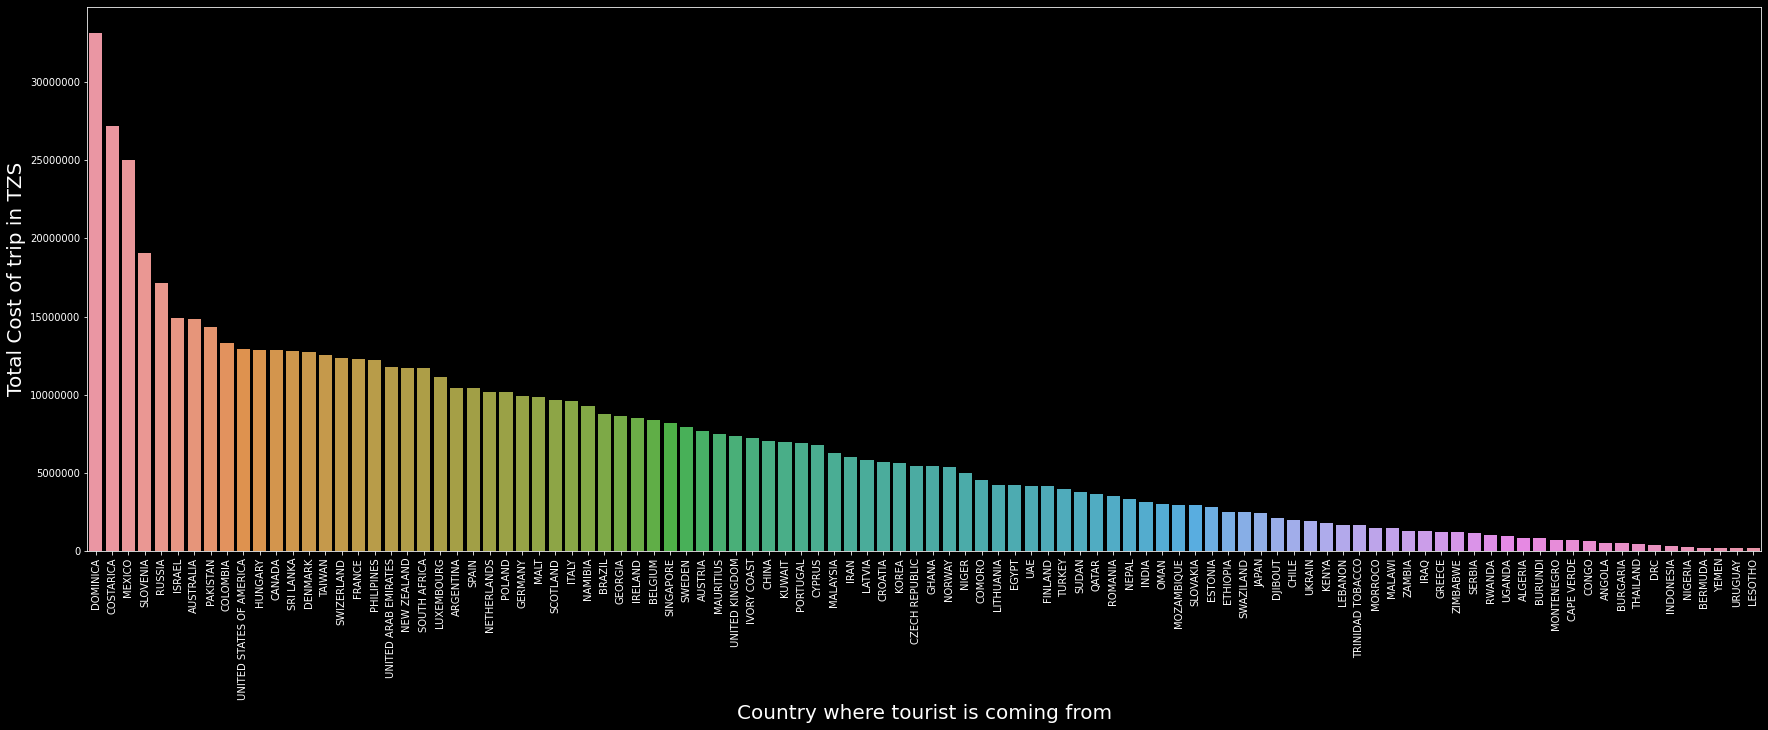

In [20]:
# Relation of total cost to country
country_df = tourism_df.groupby(['country']).mean()['total_cost'].reset_index()

fig, axes = plt.subplots(1,1, figsize=(30, 10))
fig = sns.barplot(x='country', y='total_cost', data=country_df, order = country_df.sort_values('total_cost', ascending = False).country)
plt.ticklabel_format(style='plain', axis='y')
axes.tick_params(axis='x', rotation=90)

fig.set_ylabel("Total Cost of trip in TZS", fontsize = 20)
fig.set_xlabel("Country where tourist is coming from", fontsize = 20)

plt.savefig('images/country_total_cost.png')
plt.show()

By far the most total cost of trips is observed for people coming from Dominica and Costarica, followed by Mexico, Slovenia and Russia.

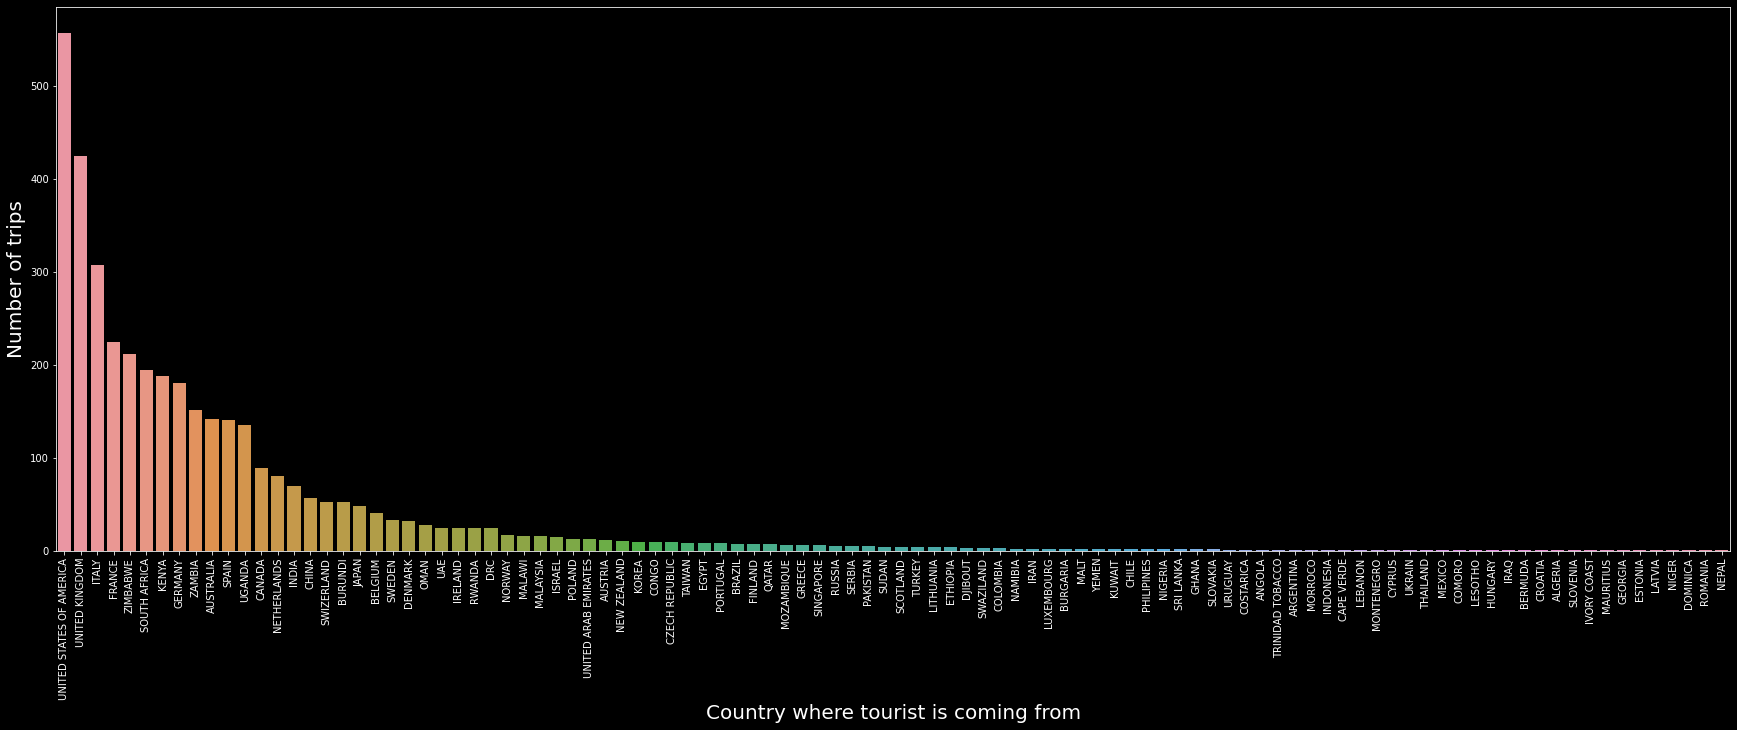

In [21]:
# plot the distribution of countries
fig, axes = plt.subplots(1,1, figsize=(30, 10))
axes.tick_params(axis='x', rotation=90)

fig = sns.countplot(x = tourism_df.country,
              order = tourism_df.country.value_counts().index)

fig.set_ylabel("Number of trips", fontsize = 20)
fig.set_xlabel("Country where tourist is coming from", fontsize = 20)

plt.savefig('images/country_distribution.png')
plt.show()


Most people going on a trip to Tantania come from the USA, UK and Italy, followed by France and Zimbabwe.

In [22]:
# Calculate number of people and number of nights total
num_cols_tourism = list(tourism_df.columns[tourism_df.dtypes!=object])
tourism_num_cols_df = tourism_df[num_cols_tourism]
tourism_num_cols_df.eval('total_people = total_female + total_male', inplace=True)
tourism_num_cols_df.eval('total_nights = night_mainland + night_zanzibar', inplace=True)
tourism_num_cols_df

,total_female,total_male,night_mainland,night_zanzibar,total_cost,total_people,total_nights
402,10.000,2.000,21.000,0.000,9116250.000,12.000,21.000
4543,1.000,1.000,6.000,7.000,7112625.000,2.000,13.000
3541,1.000,0.000,26.000,2.000,8250645.000,1.000,28.000
2377,0.000,1.000,7.000,0.000,828750.000,1.000,7.000
4584,1.000,1.000,6.000,0.000,3107600.000,2.000,6.000
...,...,...,...,...,...,...,...
4426,0.000,1.000,60.000,0.000,1150000.000,1.000,60.000
466,6.000,6.000,7.000,0.000,11380200.000,12.000,7.000
3092,0.000,1.000,10.000,0.000,675000.000,1.000,10.000
3772,0.000,1.000,1.000,0.000,994500.000,1.000,1.000


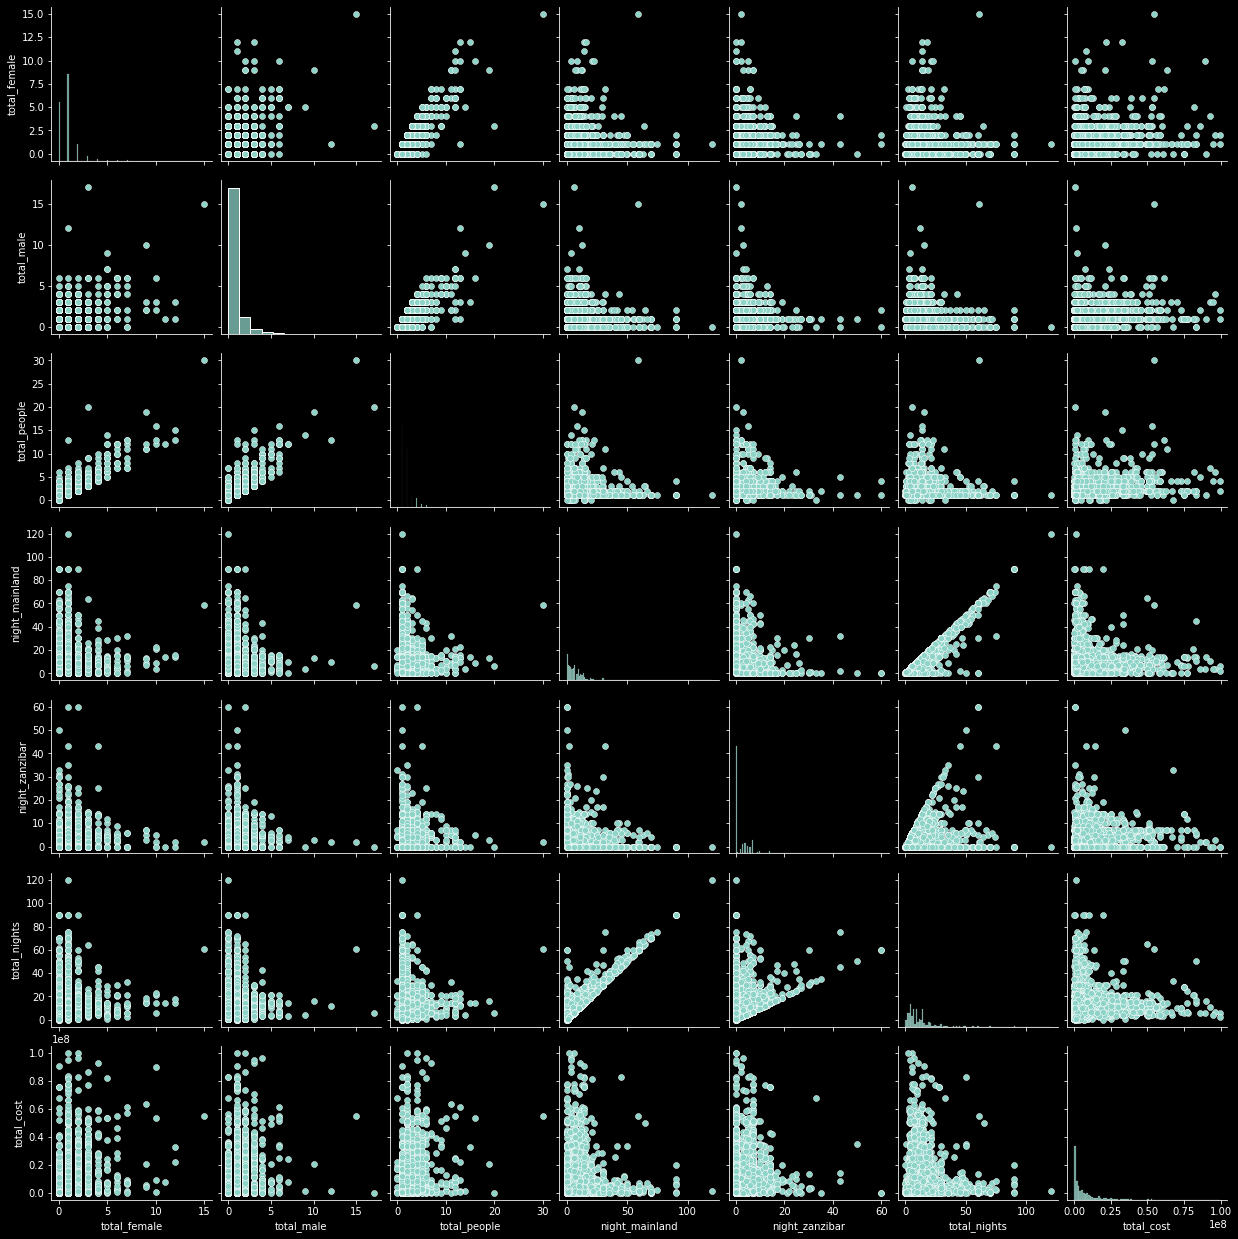

In [23]:
# overview of all numerical features and the target variable
# temporarily remove outlier before plotting
outlier_index = tourism_num_cols_df.query('total_female > 40').index

sns.pairplot(tourism_num_cols_df.drop(outlier_index, axis=0)[['total_female', 'total_male','total_people', 'night_mainland', 'night_zanzibar', 'total_nights', 'total_cost']])
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('images/pairplot_numerical_features.png')
plt.show()


There is no remarkable relation visible between the numerical columns.

In [24]:
# Checking if there is at least one person travelling
tourism_df.query('total_female + total_male ==0')

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
170,tour_1205,UNITED STATES OF AMERICA,25-44,Spouse,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Radio, TV, Web",Package Tour,No,Yes,Yes,Yes,No,Yes,No,5.000,4.000,Credit Card,No,Excellent Experience,1657500.000
1670,tour_3040,ZIMBABWE,1-24,Alone,0.000,0.000,Business,Beach tourism,"Newspaper, magazines,brochures",Independent,No,No,No,No,No,No,No,2.000,0.000,Cash,No,No comments,500000.000
727,tour_1893,UNITED STATES OF AMERICA,45-64,Spouse and Children,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,20.000,0.000,Cash,Yes,Friendly People,19227000.000
2335,tour_3840,SPAIN,25-44,Alone,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,Yes,Yes,Yes,No,Yes,No,4.000,0.000,Cash,Yes,"Wonderful Country, Landscape, Nature",447525.000
2430,tour_396,AUSTRALIA,1-24,Alone,0.000,0.000,Leisure and Holidays,Hunting tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,15.000,5.000,Cash,Yes,Friendly People,11027030.000
3864,tour_5689,UGANDA,25-44,Alone,0.000,0.000,Visiting Friends and Relatives,Hunting tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,3.000,0.000,Cash,No,Friendly People,200000.000
3814,tour_5631,UNITED KINGDOM,25-44,Friends/Relatives,0.000,0.000,Leisure and Holidays,Cultural tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,14.000,7.000,Cash,Yes,Friendly People,4552080.000
3224,tour_4901,FRANCE,25-44,Friends/Relatives,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,3.000,4.000,Cash,Yes,Wildlife,17403750.000
706,tour_1869,UNITED STATES OF AMERICA,45-64,NaN,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,No,Yes,Yes,7.000,0.000,Cash,Yes,No comments,21713250.000
2243,tour_3730,UNITED STATES OF AMERICA,65+,Spouse,0.000,0.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,Yes,Yes,Yes,No,No,No,14.000,0.000,Cash,Yes,Wildlife,16939650.000


This is strange, because there should be always at least one person travelling.
Those rows will still be kept in the dataset. Besides looking at these two columns compared, the data seems to be alright. The values of those two columns won't matter that much since they are also valid when looking at them separately.

In [25]:
# Examine missing value in column most_impressing
tourism_df.most_impressing.value_counts()

Friendly People                         1220
 Wildlife                                837
No comments                              597
Wonderful Country, Landscape, Nature     415
Good service                             292
Excellent Experience                     218
Satisfies and Hope Come Back              23
Name: most_impressing, dtype: int64

In [26]:
# Examine missing value in column travel_with
print(tourism_df.travel_with.value_counts())

# percentage of missing values
print(f'{(tourism_df.travel_with.isnull().sum() / tourism_df.shape[0] * 100).round(2)} percent of values missing')


Alone                  988
Spouse                 819
Friends/Relatives      727
Spouse and Children    289
Children               133
Name: travel_with, dtype: int64
23.16 percent of values missing


# Data cleaning and feature engineering

In [27]:
# MASTERPLAN
# Needed cleaning and transformations:

# Before setting up Baseline model:
# Remove outliers

# Pipeline for transforming data:
# SimpleImputer - impute missing values in columns total_female and total_male with median (because it seems more reasonable for the number of people)
# SimpleImputer - impute missing values in column travel_with with 'missing', since there is 23% missing and this is too much to impute with mode
# SimpleImputer - impute missing values in column most_impressing with 'No comments', since that is a valid and frequently occuring category and NaN feels like no comment was given on this question

# StandardScaler - scale numerical features with standard scaler
# OneHotEncoder - One-hot-encode categorical features

# FunctionTransformer - Log-transform target data

## Handling Outliers in the numeric features

In [28]:
# Find outliers with z-score

df_zscore_total_female  = zscore(X_train.total_female.fillna(X_train.total_female.median()))
df_zscore_total_male  = zscore(X_train.total_male.fillna(X_train.total_male.median()))
df_zscore_night_mainland  = zscore(X_train.night_mainland.fillna(X_train.night_mainland.median()))
df_zscore_night_zanzibar  = zscore(X_train.night_zanzibar.fillna(X_train.night_zanzibar.median()))
#df_zscore_total_cost  = zscore(tourism_df.total_cost)

df_scores = pd.concat([df_zscore_total_female, df_zscore_total_male, df_zscore_night_mainland, df_zscore_night_zanzibar], axis=1)

#df_scores.sort_values(['total_female'])
#print(df_scores.max())

# Calculate data loss based on 3.5 standard deviations of these 4 numeric features
#print(X_train.shape)
loss_percentage = df_scores.query('total_female > 4 or total_male > 4 or night_mainland > 4 or night_zanzibar > 4').count()['total_female'] / X_train.shape[0] * 100
loss_rows = df_scores.query('total_female > 4 or total_male > 4 or night_mainland > 4 or night_zanzibar > 4')['total_female']

print(f'Percentage of data loss of the training data based on 4 standard deviations for the numeric features: {loss_percentage.round(2)}%')
print(f'Nuber of rows to be removed: {loss_rows.count().round(3)}')


Percentage of data loss of the training data based on 4 standard deviations for the numeric features: 3.02%
Nuber of rows to be removed: 116


In [29]:
# Remove outliers from train data
# EXECUTE ONLY ONCE!
print(loss_rows.index)
X_train.drop(loss_rows.index, axis=0, inplace=True)
y_train.drop(loss_rows.index, axis=0, inplace=True)

Int64Index([ 402,  650, 3821, 4431, 1042,  174, 1228, 4562,   52,   30,
            ...
            1154,  854, 4745, 2690, 2695, 1076,  775,  474, 4426,  466],
           dtype='int64', length=116)


## Error analysis - Deep dive into difference of high and low total cost

In [30]:
X_train.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
4543,tour_675,UNITED KINGDOM,1-24,Friends/Relatives,1.000,1.000,Leisure and Holidays,Conference tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,6.000,7.000,Cash,Yes,Wildlife
3541,tour_529,UNITED KINGDOM,1-24,NaN,1.000,0.000,Volunteering,Wildlife tourism,"Friends, relatives",Package Tour,No,Yes,Yes,Yes,Yes,No,No,26.000,2.000,Cash,Yes,No comments
2377,tour_3894,ZIMBABWE,25-44,Alone,0.000,1.000,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,7.000,0.000,Cash,No,NaN
4584,tour_724,UNITED KINGDOM,25-44,Spouse,1.000,1.000,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,6.000,0.000,Cash,No,Friendly People
1777,tour_3166,ITALY,25-44,Friends/Relatives,2.000,2.000,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,No,No,Yes,No,7.000,7.000,Cash,Yes,"Wonderful Country, Landscape, Nature"


In [31]:
# Compare travellers with high to low total_cost
train_data_all_df = pd.concat([X_train,y_train], axis=1)

# Divide travellers in those who have high total_cost and those with low total_cost
low_cost_df = train_data_all_df.query('total_cost <= 10000000')  #2818 rows
high_cost_df = train_data_all_df.query('total_cost > 10000000')  #913 rows

no_low = low_cost_df.shape[0]
no_high = high_cost_df.shape[0]

# Create feature groups
# Country not included because there are too many categories in this feature
percentage_grouped_low = low_cost_df.groupby(['main_activity', 'age_group', 'travel_with', 'purpose', 'payment_mode', 'info_source', 'tour_arrangement', 'first_trip_tz', 'country','most_impressing']).count()['ID'] / no_low
percentage_grouped_low = percentage_grouped_low.reset_index()
percentage_grouped_high = high_cost_df.groupby(['main_activity', 'age_group', 'travel_with', 'purpose', 'payment_mode', 'info_source', 'tour_arrangement', 'first_trip_tz', 'country','most_impressing']).count()['ID'] / no_high
percentage_grouped_high = percentage_grouped_high.reset_index()

# join basemodel_train to test data
percentage_total = percentage_grouped_low.merge(percentage_grouped_high, on=['main_activity', 'age_group', 'travel_with', 'purpose', 'payment_mode', 'info_source', 'tour_arrangement', 'first_trip_tz', 'country','most_impressing'], suffixes=('_low', '_high'), how='outer')
percentage_total.rename(columns={'ID_low': 'percentage_low_cost', 'ID_high': 'percentage_high_cost'}, inplace=True)


In [32]:

percentage_total.sort_values('tour_arrangement').head(30)

#percentage_total.shape[0] # 2285# feature groups

percentage_total.isnull().sum()
# 580 of total groups do not exist for low total_cost
# 1625 of total groups do not exist for high total_cost
# --> not enough data to represent the high total_cost group for some feature-combinations!!

#percentage_total[percentage_total['percentage_high_cost'].notnull()]

#percentage_total.sort_values('percentage_high_cost')

main_activity              0
age_group                  0
travel_with                0
purpose                    0
payment_mode               0
info_source                0
tour_arrangement           0
first_trip_tz              0
country                    0
most_impressing            0
percentage_low_cost      580
percentage_high_cost    1625
dtype: int64

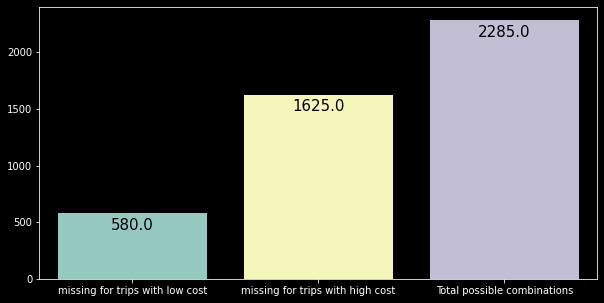

In [33]:
low_high = [580, 1625, int(percentage_total.shape[0])]
labels = ['missing for trips with low cost', 'missing for trips with high cost', 'Total possible combinations']
low_high

fig, axes = plt.subplots(1,1, figsize=(10, 5))
fig = sns.barplot(labels, low_high)


for p in fig.patches:
    fig.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   color='Black',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.savefig('images/missing_data_low_vs_high_cost.png')
plt.show()

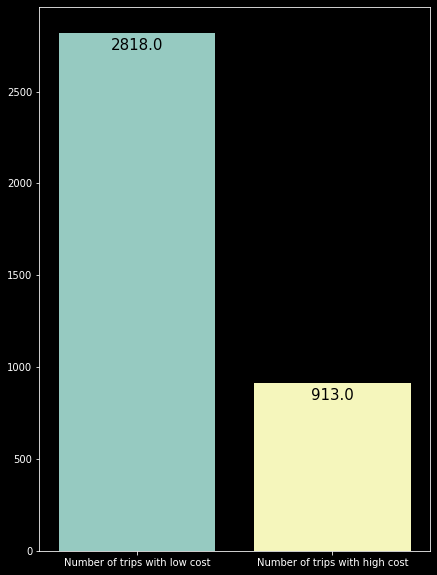

In [34]:
low_high = [low_cost_df.shape[0], high_cost_df.shape[0]]
labels = ['Number of trips with low cost', 'Number of trips with high cost']
low_high

fig, axes = plt.subplots(1,1, figsize=(7, 10))
fig = sns.barplot(labels, low_high)

for p in fig.patches:
    fig.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   color='Black',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.savefig('images/number_trips_low_vs_high_cost.png')
plt.show()


For the group of travellers with high total_cost, it seems that they are only centered in a few groups of feature-combinations.
</br>
The dataset is too small to be assessed by these many features.
</br>
Perhaps feature reduction could help.

## Impute package columns based on tour_arrangement

There are boolean columns that are only relevant for Package Tours, but they are also filled with 'No' for the Independent travellers. This might disturb the model!

In [35]:
all_columns = list(X_train.columns)

# get list of all columns that only concern Package Tours
package_columns = [col for col in all_columns if 'package' in col]

package_columns
#X_train[X_train['tour_arrangement'] == "Independent"].index

X_train_imputed_package = X_train.copy()
X_test_imputed_package = X_test.copy()
# Replace values of package columns with 'Irrelevant' vor Independent travellers
X_train_imputed_package.loc[X_train['tour_arrangement'] == 'Independent', package_columns] = 'Irrelevant'
X_test_imputed_package.loc[X_test['tour_arrangement'] == 'Independent', package_columns] = 'Irrelevant'

#TODO: This needs to go into the Pipeline!!


## Drop package columns version

In [36]:
# Try a version without package columns
X_train_without_package_cols = X_train.drop(package_columns, axis=1)
X_test_without_package_cols = X_test.drop(package_columns, axis=1)

In [37]:
X_test_without_package_cols

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
1448,tour_2776,NEPAL,25-44,Friends/Relatives,0.000,2.000,Visiting Friends and Relatives,Beach tourism,"Travel, agent, tour operator",Package Tour,12.000,0.000,Cash,No,Wildlife
2932,tour_457,NORWAY,45-64,Alone,0.000,1.000,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,11.000,3.000,Cash,No,Wildlife
794,tour_1971,UNITED STATES OF AMERICA,25-44,NaN,0.000,1.000,Volunteering,Wildlife tourism,"Radio, TV, Web",Independent,10.000,0.000,Cash,Yes,Friendly People
1029,tour_2263,ZIMBABWE,25-44,Alone,0.000,1.000,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,6.000,0.000,Cash,No,Friendly People
8,tour_101,NIGERIA,25-44,Alone,0.000,1.000,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,4.000,0.000,Cash,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,tour_2250,SOUTH AFRICA,25-44,NaN,0.000,1.000,Business,Wildlife tourism,"Newspaper, magazines,brochures",Package Tour,4.000,0.000,Cash,Yes,No comments
2803,tour_4413,ITALY,25-44,Spouse,1.000,1.000,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Package Tour,0.000,7.000,Cash,Yes,No comments
198,tour_1241,SOUTH AFRICA,25-44,Alone,0.000,1.000,Business,Mountain climbing,others,Independent,12.000,0.000,Cash,No,Friendly People
4417,tour_635,ITALY,45-64,Spouse and Children,2.000,2.000,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,7.000,6.000,Credit Card,No,No comments


## First Simple Baseline Model

Because of a significant difference of mean total_cost within the categories of age_group, purpose, main_activity, tour_arrangement and payment_mode, it is assumed that the total_cost can be predicted by taking the mean total_cost grouped by these 5 categorical features.
Some combinations of the categories of these 5 features can be found in the test data but do not exist in the train data. Therefore, to fill in the missing mean values based on 5 features, the mean of total_cost grouped only by 2 features, age_group and tour_arrangement, is calculated.

In [38]:
# Concatenate 5 base features and target value
basemodel_data_train = pd.concat([X_train[['age_group','purpose','main_activity','tour_arrangement','payment_mode']],y_train], axis=1)

# group data by base features and calculate mean of total_cost
basemodel_train = basemodel_data_train.groupby(['age_group','purpose','main_activity','tour_arrangement','payment_mode']).mean()['total_cost'].reset_index()

# Take easier model with only two features to impute missing values of first prediction where all 5 features in combination do not match test data
# Concatenate 2 base features and target value
basemodel_data_train_2features = pd.concat([X_train[['age_group','tour_arrangement']],y_train], axis=1)

# group data by base features and calculate mean of total_cost
basemodel_train_2_features = basemodel_data_train_2features.groupby(['age_group','tour_arrangement']).mean()['total_cost'].reset_index()

In [39]:
# Make baseline predictions for train dataset

# Concatenate base features and target value
basemodel_data_train = X_train[['age_group','purpose','main_activity','tour_arrangement','payment_mode']]

# join basemodel_train to train data
predictions_train = basemodel_data_train.merge(basemodel_train, on=['age_group','purpose','main_activity','tour_arrangement','payment_mode'], suffixes=('_test', '_train'), how='left')

y_pred_train_basemodel = predictions_train['total_cost']


In [40]:
# Make baseline predictions for test dataset

# Concatenate base features and target value
basemodel_data_test = pd.concat([X_test[['age_group','purpose','main_activity','tour_arrangement','payment_mode']],y_test], axis=1)

# join basemodel_train to test data
predictions_5_features = basemodel_data_test.merge(basemodel_train, on=['age_group','purpose','main_activity','tour_arrangement','payment_mode'], suffixes=('_actual', '_5features'), how='left')

#print(predictions_5_features.isnull().sum()) # 29 predictions missing!
#print(predictions_5_features)

# join basemodel_train_2features to predictions to fill the gaps
predictions_5_2_features = predictions_5_features.merge(basemodel_train_2_features, on=['age_group','tour_arrangement'], how='left')
predictions_5_2_features.rename(columns={'total_cost': 'total_cost_2features'}, inplace=True)

#predictions_5_2_features.isnull().sum()

# for final prediction, take prediction with 5 features and fill NaNs with prediction for 2 features
predictions_5_2_features['total_cost_final_pred'] = predictions_5_2_features['total_cost_5features']
predictions_5_2_features['total_cost_final_pred'] = predictions_5_2_features['total_cost_final_pred'].fillna(value = predictions_5_2_features['total_cost_2features'])

#print(predictions_5_2_features)

y_pred_test_basemodel = predictions_5_2_features['total_cost_final_pred']
y_act_test_basemodel = predictions_5_2_features['total_cost_actual']


Remark: The total_cost are in TZS (Tansania-Schilling). The conversion rate is as follows: 1 EUR = 2628.57 TZN
</br>
RMSE is chosen as metric because it is best for the customer to see the amount of error directly in the common currency. Furthermore, because it is a squared metric, higher errors have a higher influence on the metric.

In [41]:
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test, print_metrics):
    # R2 can only be used to assess train data
    r2 = r2_score(y_train, y_pred_train)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    mae = mean_absolute_error(y_test, y_pred_test)
    metrics = {'r2' : r2,
                'rmse' : rmse,
                'mae' : mae}

    if print_metrics:
        print(f'R2: {r2}')

        print(f'RMSE in TZS: {rmse}')
        print(f'RMSE in EUR: {rmse / TZS_RATE}')

        print(f'MAE in TZS: {mae}')
        print(f'MAE in EUR: {mae / TZS_RATE}')

    return metrics


In [42]:
# Metrics for test data
calculate_metrics(y_train, y_pred_train_basemodel, y_act_test_basemodel,y_pred_test_basemodel, True)

R2: 0.36424844392313016
RMSE in TZS: 10410608.879672198
RMSE in EUR: 3960.5598784404438
MAE in TZS: 5869738.415709746
MAE in EUR: 2233.0538717666814


{'r2': 0.36424844392313016,
 'rmse': 10410608.879672198,
 'mae': 5869738.415709746}

In [43]:
# Metrics for train data
calculate_metrics(y_train, y_pred_train_basemodel, y_train,y_pred_train_basemodel, True)

R2: 0.36424844392313016
RMSE in TZS: 9650893.259414181
RMSE in EUR: 3671.5374745257614
MAE in TZS: 5298125.39875605
MAE in EUR: 2015.5922797399535


{'r2': 0.36424844392313016, 'rmse': 9650893.259414181, 'mae': 5298125.39875605}

In [44]:
y_test.std()

11888932.28137837

Conclusion: The RMSE of the baseline prediction is just a little bit better than the standard deviation.

Error Analysis of basemodel

In [45]:
def plot_act_vs_pred(y_true, y_pred, image_name):
    fig, axes = plt.subplots(1,1, figsize=(15, 10))
    fig = sns.scatterplot(y_pred, y_true)

    # plot line for ideal prediction
    x = np.linspace(0,max(y_pred),5000000)
    y = x
    plt.plot(x, y, '-r', label='y=x')

    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    fig.set_ylabel("Actual values", fontsize = 20)
    fig.set_xlabel("Predicted values", fontsize = 20)
    plt.yticks(range(0, int(max(y_true)), 10000000))
    plt.xticks(range(0, int(max(y_pred)), 5000000))

    plt.savefig(f'images/{image_name}.png')
    plt.plot()

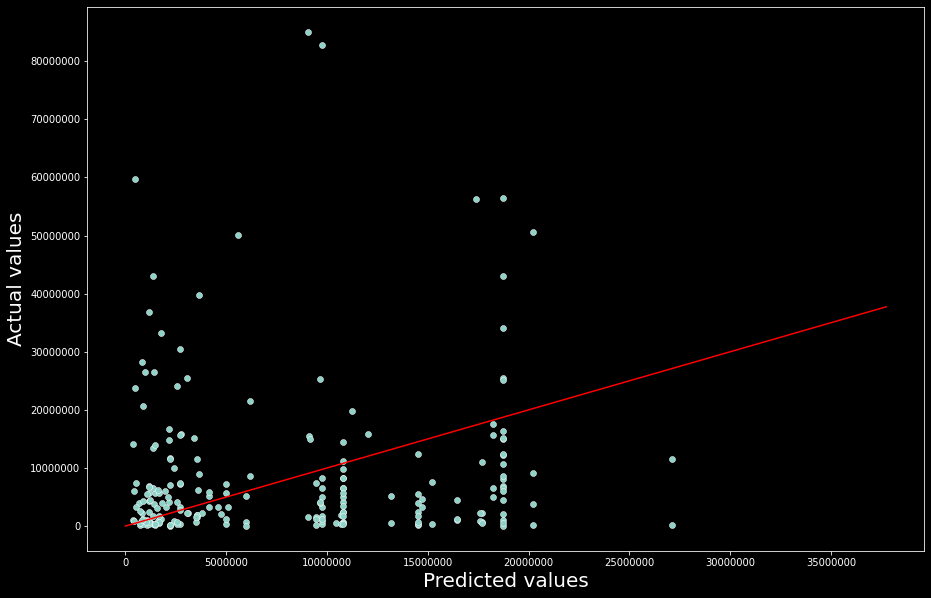

In [46]:
# Plot actual vs. predicted value for the baseline model
plot_act_vs_pred(y_test, y_pred_test_basemodel, 'basemodel_act_vs_pred_values')

The red line shows the ideal prediction where the actual total cost would be the predicted total cost
</br>
The baseline model overestimates lower actual total costs and underestimates higher total costs.

In [47]:
def residual_plot(y_test, y_pred_test, image_name, y_train=None, y_pred_train=None):

    # convert lists to arrays
    y_test = np.array(y_test)
    y_pred_test = np.array(y_pred_test)

    # Calculate difference of actual total_cost and predicted total_cost for test data
    y_pred_diff = y_pred_test - y_test

    # plot actual total_cost vs. difference between actual and predicted value
    fig, axes = plt.subplots(1,1, figsize=(15, 10))

    if y_train is None:
        fig = sns.scatterplot(x=y_pred_test, y=y_pred_diff)
        plt.xticks(range(-10000000, int(max(y_pred_test)), 10000000))
    else:
        y_train = np.array(y_train)
        y_pred_train = np.array(y_pred_train)

        num_test = len(y_test)
        num_train = len(y_train)
        y_test_total = np.concatenate((y_train, y_test))
        y_pred_total = np.concatenate((y_pred_train, y_pred_test))
        y_pred_diff_total = y_pred_total - y_test_total
        train_test_num = ['train data' for i in range(num_train)] + ['test data' for i in range(num_test)]

        fig = sns.scatterplot(x=y_pred_total, y=y_pred_diff_total, hue=train_test_num, alpha=0.7, palette=["yellow", "blue"])
        plt.xticks(range(-10000000, max(int(max(y_pred_train)), int(max(y_pred_test))), 10000000))

    plt.axhline(0, c='red')

    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='x')
    fig.set_xlabel("Predicted values", fontsize = 20)
    fig.set_ylabel("Standardized Residual", fontsize = 20)

    plt.yticks(range(-80000000, int(max(y_pred_diff)), 10000000))
    

    plt.savefig(f'images/{image_name}.png')
    plt.plot()


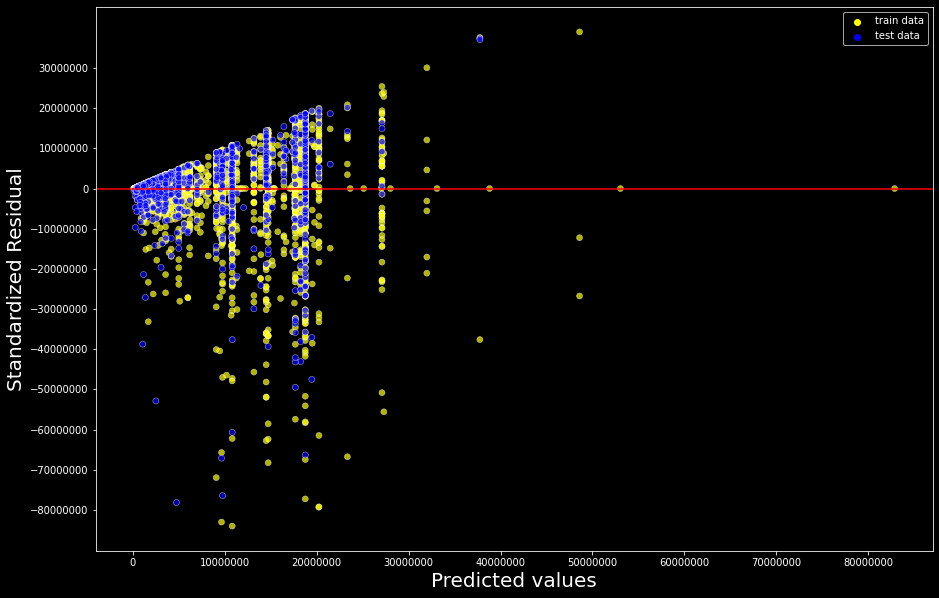

In [48]:
# Plot the relation of actual value and the difference between actual and predicted values for the baseline model
residual_plot(y_test, y_pred_test_basemodel,'basemodel_residual_plot', y_train=y_train, y_pred_train=y_pred_train_basemodel)

In average, for lower total_cost, the prediction is too high and for higher total_cost it is too low. 
</br>
Amazing: The error seems to be linear.

## Log transform target data

In [49]:
log_transformer = FunctionTransformer(
        func=np.log1p,
        inverse_func=np.expm1
    )


y_train_log = log_transformer.transform(y_train)
y_test_log = log_transformer.transform(y_test)

## Building a Pipeline

In [50]:
# Create feature lists for different kinds of pipelines

impute_median_features = ['total_female', 'total_male']      # num_features
impute_missing_features = ['travel_with']                    # cat_feature
impute_no_comments_features = ['most_impressing']            # cat_feature

# ID is a unique identifier for each tourist and therefore not relevant for the model
drop_features = ['ID']                                      # cat_feature


num_features = list(X_train.columns[X_train.dtypes!=object])
# remove items that also need to go through imputation
num_features = [x for x in num_features if x not in impute_median_features]

cat_features = list(X_train.columns[X_train.dtypes==object])
# remove items that also need to go through imputation or need to be dropped
cat_features = [x for x in cat_features if x not in impute_missing_features and x not in impute_no_comments_features and x not in drop_features]

In [51]:
# Create preprocessing pipelines

impute_median_pipeline = Pipeline([
   ('imputer_num', SimpleImputer(strategy='median')),
   ('std_scaler', StandardScaler())
])

impute_missing_pipeline = Pipeline([
   ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   ('1hot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

impute_no_comments_pipeline = Pipeline([
   ('imputer_cat', SimpleImputer(strategy='constant', fill_value='No comments')),
   ('1hot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

num_pipeline = Pipeline([
   ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
   ('1hot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create preprocessor
# ColumnTransformer: Any columns not specified in the list of “transformers” are dropped from the dataset by default.
preprocessor = ColumnTransformer([
   ('median', impute_median_pipeline, impute_median_features),
   ('missing', impute_missing_pipeline, impute_missing_features),
   ('nocomment', impute_no_comments_pipeline, impute_no_comments_features),
   ('num', num_pipeline, num_features),
   ('cat', cat_pipeline, cat_features)
])


In [52]:
# Create new preprocessor for version with dropped package columns
cat_features_wopack = [feature for feature in cat_features if feature not in package_columns]

preprocessor_wopack = ColumnTransformer([
   ('median', impute_median_pipeline, impute_median_features),
   ('missing', impute_missing_pipeline, impute_missing_features),
   ('nocomment', impute_no_comments_pipeline, impute_no_comments_features),
   ('num', num_pipeline, num_features),
   ('cat', cat_pipeline, cat_features_wopack)
])


In [53]:
pipe_linreg = Pipeline([
   ('preprocessor', preprocessor),
   ('linreg', LinearRegression())
])


## Training a simple Linear Regression model

In [54]:
# Train model (without log-transformation of target)
pipe_linreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('median',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['total_female',
                                                   'total_male']),
                                                 ('missing',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('1h

In [55]:
# Make predictions
y_pred_test_linreg = pipe_linreg.predict(X_test)
y_pred_train_linreg = pipe_linreg.predict(X_train)

In [56]:
# Calculate metrics for Linear Regression Model for test data
calculate_metrics(y_train, y_pred_train_linreg, y_test,y_pred_test_linreg, print_metrics=True)


R2: 0.40474331411024056
RMSE in TZS: 9517464.556794714
RMSE in EUR: 3620.776527463493
MAE in TZS: 5784403.579653913
MAE in EUR: 2200.589514319159


{'r2': 0.40474331411024056,
 'rmse': 9517464.556794714,
 'mae': 5784403.579653913}

In [57]:
# Calculate metrics for Linear Regression Model for train data
calculate_metrics(y_train, y_pred_train_linreg, y_train,y_pred_train_linreg, print_metrics=True)

R2: 0.40474331411024056
RMSE in TZS: 9338474.503719423
RMSE in EUR: 3552.682448525024
MAE in TZS: 5506202.820931284
MAE in EUR: 2094.7522116326686


{'r2': 0.40474331411024056,
 'rmse': 9338474.503719423,
 'mae': 5506202.820931284}

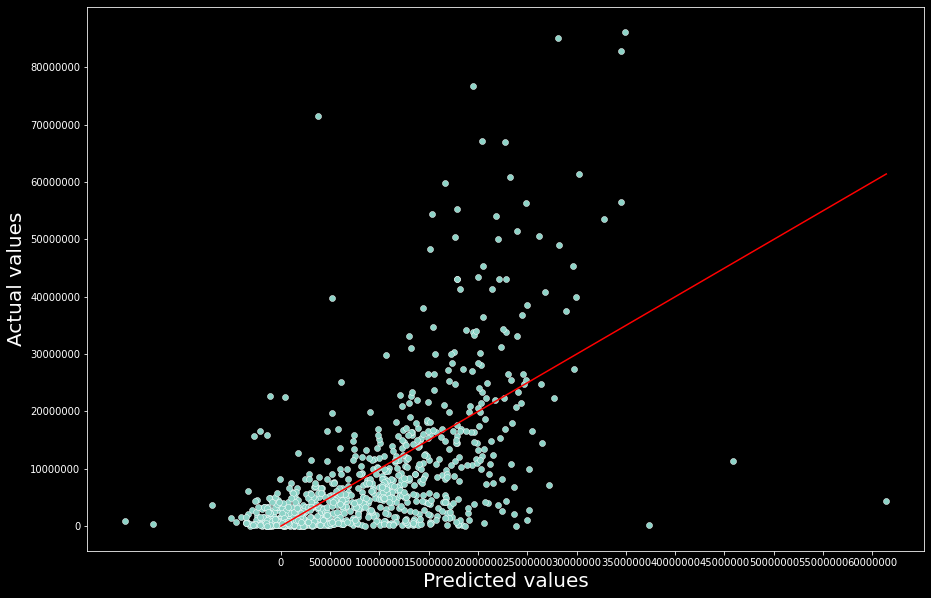

In [58]:
# Plot actual vs. predicted value for the model
plot_act_vs_pred(y_test, y_pred_test_linreg, 'lin_act_vs_pred_values')

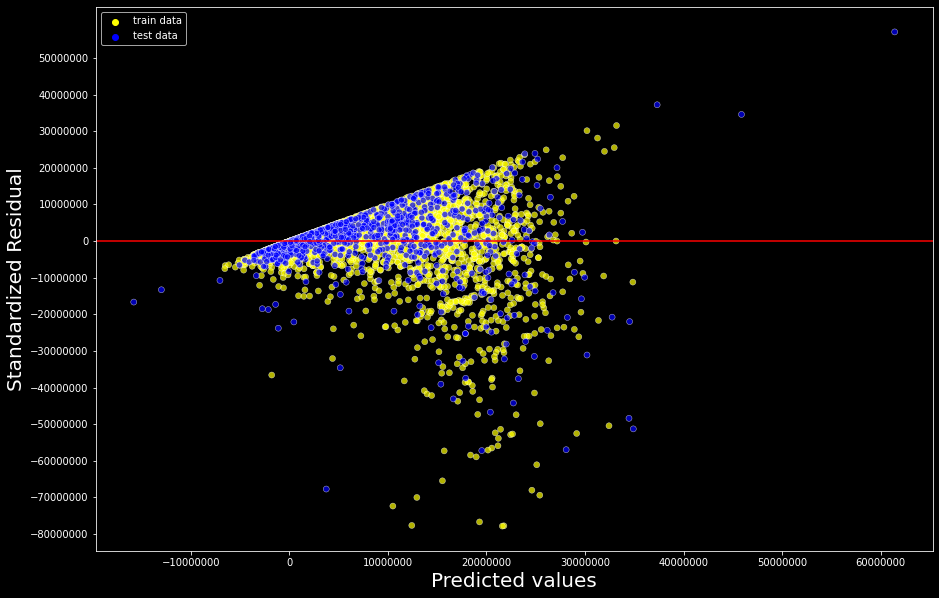

In [59]:
# Plot the relation of actual value and the difference between actual and predicted value
residual_plot(y_test, y_pred_test_linreg,'lin_residual_plot', y_train, y_pred_train_linreg)

In [60]:
# Train model again with log-transformation of target
pipe_linreg_log = Pipeline([
   ('preprocessor', preprocessor),
   ('linreg', LinearRegression())
])

pipe_linreg_log.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('median',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['total_female',
                                                   'total_male']),
                                                 ('missing',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('1h

In [61]:
# Make predictions and inverse log-transformation
y_pred_test_linreg_log = pipe_linreg_log.predict(X_test)
y_pred_test_linreg_invlog = log_transformer.inverse_func(y_pred_test_linreg_log)

y_pred_train_linreg_log = pipe_linreg_log.predict(X_train)
y_pred_train_linreg_invlog = log_transformer.inverse_func(y_pred_train_linreg_log)

In [62]:
# Calculate metrics for Linear Regression Model for test data without log-transformation
calculate_metrics(y_train, y_pred_train_linreg_invlog, y_test,y_pred_test_linreg_invlog, print_metrics=True)

R2: 0.3100052036569072
RMSE in TZS: 9948151.377062261
RMSE in EUR: 3784.624863352416
MAE in TZS: 4863415.477537138
MAE in EUR: 1850.2134154833761


{'r2': 0.3100052036569072, 'rmse': 9948151.377062261, 'mae': 4863415.477537138}

Log-transformation of the target-value made the result worse for linear regression!

## Quick overview of performance for different classifiers

In [63]:
# backup
# def model_evaluation(regressor, X_train, y_train, preprocessor = preprocessor):
#     # only use for data that is not log-transformed!
#     pipe_regressor = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', regressor)
#     ])

#     scores = cross_validate(pipe_regressor, X_train, y_train, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'], cv=10, n_jobs=-1)
#     results = {key + '_mean': value.mean().round(4) * (-1.0) for key, value in scores.items()}
#     results_std = {key + '_std': value.std().round(4) for key, value in scores.items()}
#     results.update(results_std)
#     results['model'] = regressor

#     del results['fit_time_mean']
#     del results['fit_time_std']
#     del results['score_time_mean']
#     del results['score_time_std']


#     return results

In [64]:
# backup
# model_results = []
# for reg in list_of_reg:
#    results = model_evaluation(reg, X_train, y_train, preprocessor)
#    print(reg)
#    print(f"RSME (mean, std): ({results['test_neg_root_mean_squared_error_mean']}, {results['test_neg_root_mean_squared_error_std']})")
#    print(f"MAE (mean, std): ({results['test_neg_mean_absolute_error_mean']}, {results['test_neg_mean_absolute_error_std']})")
#    print("----"*10)
#    model_results.append(results)


In [65]:
def model_evaluation_log(regressor, X_train, y_train, preprocessor = preprocessor, log=False, version=''):

    if version == 'wopack':
        pipe_regressor = Pipeline([
            ('preprocessor', preprocessor_wopack),
            ('regressor', regressor)
        ])
    else:
        pipe_regressor = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', regressor)
        ])

    y_pred = cross_val_predict(pipe_regressor, X_train, y_train, cv=10, n_jobs=-1)

    results = {}
    if log:
        y_pred = log_transformer.inverse_func(y_pred)

    results['model'] = regressor
    results['rmse'] = mean_squared_error(y_train, y_pred, squared=False)
    results['mae'] = mean_absolute_error(y_train, y_pred)
    results['version'] = 'normal' + version if not log else 'log' + version
    results['y_pred'] = y_pred
    return results

In [66]:

# Evaluate different models to make the decision for the best of them to be further adjusted
list_of_estimators = [('lr', LinearRegression()),
                     ('dt', DecisionTreeRegressor(random_state=42)),
                     ('svm', SVR()),
                     ('knn', KNeighborsRegressor()),
                     ('rf', RandomForestRegressor())]

stacking_final_estimator = RandomForestRegressor()

list_of_reg = [LinearRegression(), 
               DecisionTreeRegressor(random_state=42), 
               SVR(), 
               KNeighborsRegressor(), 
               RandomForestRegressor(random_state=42), 
               AdaBoostRegressor(random_state=42), 
               XGBRegressor(random_state=42), 
               VotingRegressor(estimators=list_of_estimators), 
               StackingRegressor(estimators=list_of_estimators, final_estimator=stacking_final_estimator)]#,
               #StackingRegressor(estimators=list_of_estimators, final_estimator=VotingRegressor(estimators=list_of_estimators))]
 
model_results = []
model_results_log = []
model_results_imp = []
model_results_imp_log = []
model_results_wopack = []
model_results_wopack_log = []

for reg in list_of_reg:
   results = model_evaluation_log(reg, X_train, y_train, preprocessor, log=False)
   results_log = model_evaluation_log(reg, X_train, y_train_log, preprocessor, log=True)

   print(results['model'])
   print(f"RSME: {results['rmse']}")
   print(f"MAE: {results['mae']}")
   print(f"RSME log: {results_log['rmse']}")
   print(f"MAE log: {results_log['mae']}")

   results_imp = model_evaluation_log(reg, X_train_imputed_package, y_train, preprocessor, log=False, version='imp')
   results_imp_log = model_evaluation_log(reg, X_train_imputed_package, y_train_log, preprocessor, log=True, version='imp')

   print(f"RSME imp: {results_imp['rmse']}")
   print(f"MAE imp: {results_imp['mae']}")
   print(f"RSME imp log: {results_imp_log['rmse']}")
   print(f"MAE imp log: {results_imp_log['mae']}")
   
   results_wopack = model_evaluation_log(reg, X_train_without_package_cols, y_train, preprocessor, log=False, version='wopack')
   results_wopack_log = model_evaluation_log(reg, X_train_without_package_cols, y_train_log, preprocessor, log=True, version='wopack')

   print(f"RSME wopack: {results_wopack['rmse']}")
   print(f"MAE wopack: {results_wopack['mae']}")
   print(f"RSME wopack log: {results_wopack_log['rmse']}")
   print(f"MAE wopack log: {results_wopack_log['mae']}")

   print("----"*10)

   model_results.append(results)
   model_results_log.append(results_log)

   model_results_imp.append(results_imp)
   model_results_imp_log.append(results_imp_log)

   model_results_wopack.append(results_wopack)
   model_results_wopack_log.append(results_wopack_log)

LinearRegression()
RSME: 9769531.951476274
MAE: 5841846.850447026
RSME log: 7912356.859404932
MAE log: 5396115.984077613
RSME imp: 9768331.39142369
MAE imp: 5838853.896571907
RSME imp log: 7931688.639414854
MAE imp log: 5401327.718665285
RSME wopack: 9874073.27930706
MAE wopack: 5959441.841853545
RSME wopack log: 7687632.70013409
MAE wopack log: 5330609.376744997
----------------------------------------
DecisionTreeRegressor(random_state=42)
RSME: 13034563.867277568
MAE: 6700916.802743769
RSME log: 15035693.89559549
MAE log: 8220224.752309986
RSME imp: 13166753.751611674
MAE imp: 6812676.8062808905
RSME imp log: 15267591.406713687
MAE imp log: 8288834.802204282
RSME wopack: 13265933.160464862
MAE wopack: 6725187.494557804
RSME wopack log: 14958805.220933335
MAE wopack log: 8124123.794440944
----------------------------------------
SVR()
RSME: 13001663.541528825
MAE: 6999375.525579169
RSME log: 9734277.426347801
MAE log: 6536432.712215914
RSME imp: 13001660.892343165
MAE imp: 6999372.14

In [67]:
# Rank results of the different models by RMSE mean
model_results_df = pd.DataFrame.from_dict(model_results)
model_results_log_df = pd.DataFrame.from_dict(model_results_log)
model_results_imp_df = pd.DataFrame.from_dict(model_results_imp)
model_results_imp_log_df = pd.DataFrame.from_dict(model_results_imp_log)
model_results_wopack_df = pd.DataFrame.from_dict(model_results_wopack)
model_results_wopack_log_df = pd.DataFrame.from_dict(model_results_wopack_log)

model_results_total_df = pd.concat([model_results_df, model_results_log_df, model_results_imp_df, model_results_imp_log_df, model_results_wopack_df, model_results_wopack_log_df], axis=0, ignore_index=True)

model_results_total_df.sort_values('rmse')


,model,rmse,mae,version,y_pred
50,AdaBoostRegressor(random_state=42),3429184.832,2737720.542,logwopack,"[1616744.8430518033, 1630905.211038361, 101202..."
32,AdaBoostRegressor(random_state=42),3564513.590,2792827.052,logimp,"[1300543.1382671527, 1300543.1382671527, 10162..."
14,AdaBoostRegressor(random_state=42),3570901.838,2799122.125,log,"[1197292.3369403407, 1702624.1896626693, 89267..."
45,LinearRegression(),7687632.700,5330609.377,logwopack,"[2423081.965353571, 4836002.366513091, 674885...."
53,"StackingRegressor(estimators=[('lr', LinearReg...",7704842.906,5254456.151,logwopack,"[2060406.0550530374, 4875085.959553013, 543085..."
35,"StackingRegressor(estimators=[('lr', LinearReg...",7865340.117,5356172.806,logimp,"[1041730.6927826275, 5598463.093851914, 645682..."
9,LinearRegression(),7912356.859,5396115.984,log,"[2316500.459843773, 4629979.53321987, 667786.9..."
27,LinearRegression(),7931688.639,5401327.719,logimp,"[2352073.377563621, 4591709.412442321, 668796...."
17,"StackingRegressor(estimators=[('lr', LinearReg...",7995056.970,5442402.498,log,"[1882027.1131128443, 7068251.319272801, 708815..."
31,RandomForestRegressor(random_state=42),8303887.529,5482685.891,logimp,"[762510.9648947576, 5081790.283087849, 1052578..."


All regressors perform better on log-transformed data!

# Caution!
</br>
These Metrics are calculated on train data!!

## Plot best model

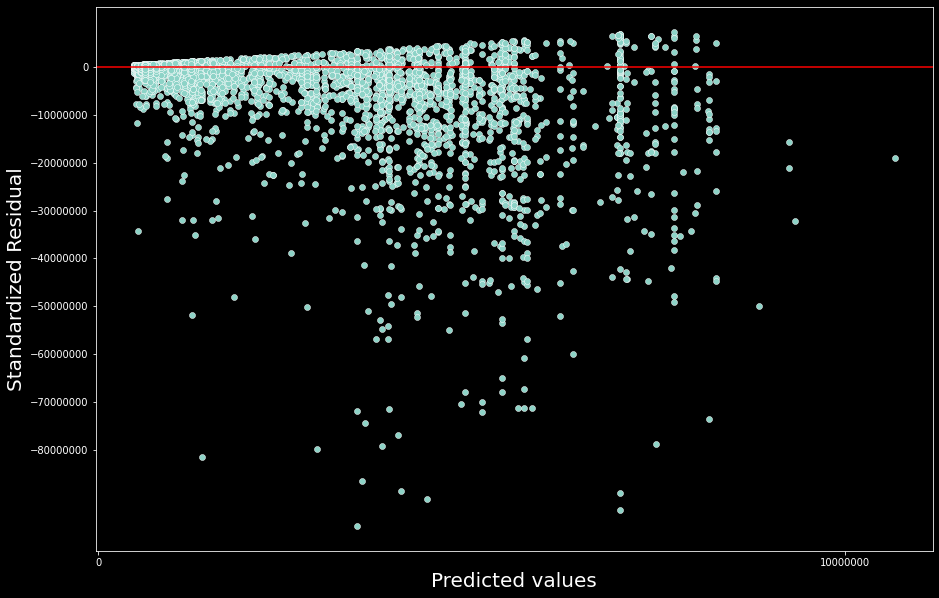

In [68]:
# Residual plot AdaBoost (log wopack)
residual_plot(y_train, model_results_total_df.loc[50, 'y_pred'],'1_adaboost_logwopack_residual_plot')

## Train AdaBoost model for log-transformed and imputed data GridSearch

In [69]:
# Backup
# Try Grid Search for RandomForestRegressor
# param_grid_rf = {
#    'regressor__n_estimators': np.linspace(10, 200).astype(int),
#    'regressor__max_depth': [None] + list(np.linspace(10, 30).astype(int)),
#    'regressor__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
#    'regressor__max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int)),
#    'regressor__min_samples_split': [10, 30, 50],
#    'regressor__bootstrap': [True, False]
# }

# pipe_regressor = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', RandomForestRegressor(random_state=42))
#     ])

# gs = GridSearchCV(pipe_regressor, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)



In [70]:
# backup
# Try Randomized Grid Search for AdaBoostRegressor
# param_grid_dtr = {"regressor__base_estimator__criterion" : ["absolute_error"], #"squared_error", 
#                   "regressor__base_estimator__splitter" :   ["best", "random"],
#                   "n_estimators": [1, 2]
#              }
# dtr = DecisionTreeRegressor()

# pipe_regressor = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', AdaBoostRegressor(base_estimator = dtr, random_state=42))
#     ])

# rand_search = RandomizedSearchCV(pipe_regressor, param_distributions=param_grid_dtr, scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1, n_iter=10)

In [71]:
# Try Randomized Grid Search for AdaBoostRegressor
param_grid = {#"regressor__base_estimator": [DecisionTreeRegressor()], # LinearRegression()], KNeighborsRegressor()],
            'regressor__n_estimators': [10, 30, 50, 70, 90],
            'regressor__learning_rate': [0.3, 0.5, 0.7, 1.0],
            'regressor__loss': ['linear', 'square', 'exponential'],
            'regressor__base_estimator__max_depth': np.arange(5,70,5),
            'regressor__base_estimator__min_samples_split': np.arange(5,30, 5),
            'regressor__base_estimator__splitter': ['best', 'random']
            }

dtreg = DecisionTreeRegressor(criterion='squared_error')

pipe_regressor = Pipeline([
        ('preprocessor', preprocessor),      #preprocessor_wopack
        ('regressor', AdaBoostRegressor(base_estimator= dtreg, random_state=42))
    ])

rand_search = RandomizedSearchCV(pipe_regressor, param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1, n_iter=100)

In [72]:
# Train Model with Adaboost, without the package columns and with log-transformed target column
rand_search.fit(X_train_imputed_package, y_train_log)          #X_train_without_package_cols    X_train_imputed_package

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('median',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['total_female',
                                                                                'total_male']),
                                                                              ('missing',
                                                                         

In [73]:
print(rand_search.best_score_ * (-1.0))
print(rand_search.best_params_)
#print(gs.best_estimator_)

best_model_ada = rand_search.best_estimator_

#{'regressor__n_estimators': 10, 'regressor__loss': 'exponential', 'regressor__learning_rate': 1.0, 'regressor__base_estimator': LinearRegression()}


1.131330082304633
{'regressor__n_estimators': 70, 'regressor__loss': 'exponential', 'regressor__learning_rate': 0.3, 'regressor__base_estimator__splitter': 'best', 'regressor__base_estimator__min_samples_split': 10, 'regressor__base_estimator__max_depth': 15}


In [74]:
y_test_pred_ada_rs_log = best_model_ada.predict(X_test)
y_test_pred_ada_rs = log_transformer.inverse_func(y_test_pred_ada_rs_log)

y_train_pred_ada_rs_log = best_model_ada.predict(X_train)
y_train_pred_ada_rs = log_transformer.inverse_func(y_train_pred_ada_rs_log)

In [75]:
calculate_metrics(y_train, y_train_pred_ada_rs, y_test, y_test_pred_ada_rs, print_metrics=True)

R2: 0.6704636238137573
RMSE in TZS: 10162114.515960744
RMSE in EUR: 3866.0239278241565
MAE in TZS: 4904172.2541942755
MAE in EUR: 1865.7187193775608


{'r2': 0.6704636238137573,
 'rmse': 10162114.515960744,
 'mae': 4904172.2541942755}

In [76]:
calculate_metrics(y_train, y_train_pred_ada_rs, y_train, y_train_pred_ada_rs, print_metrics=True)

R2: 0.6704636238137573
RMSE in TZS: 6948250.656832399
RMSE in EUR: 2643.357664750187
MAE in TZS: 3197033.44646796
MAE in EUR: 1216.2633852124766


{'r2': 0.6704636238137573, 'rmse': 6948250.656832399, 'mae': 3197033.44646796}

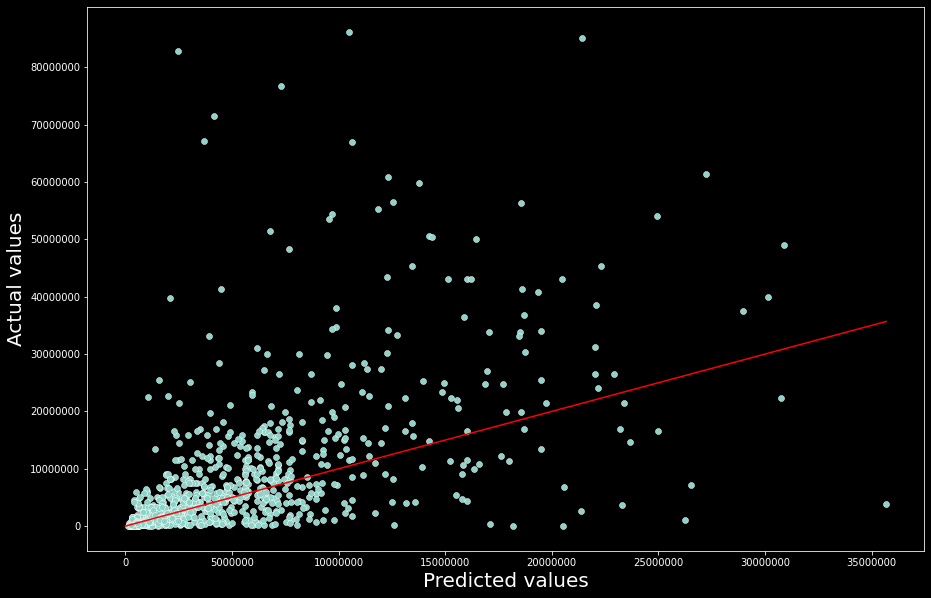

In [77]:
# Plot actual vs. predicted value for the model
plot_act_vs_pred(y_test, y_test_pred_ada_rs, 'ada_randsearch_act_vs_pred_values')

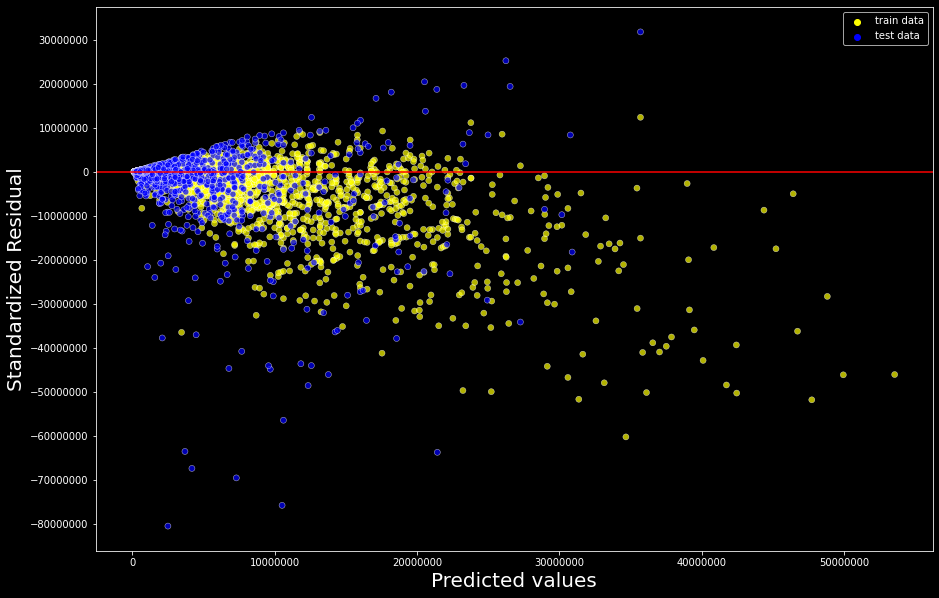

In [78]:
# Plot the relation of actual value and the difference between actual and predicted value
residual_plot(y_test, y_test_pred_ada_rs,'ada_randsearch_residual_plot', y_train, y_train_pred_ada_rs)

In [79]:
#{'regressor__n_estimators': 10, 'regressor__loss': 'exponential', 'regressor__learning_rate': 1.0, 'regressor__base_estimator': LinearRegression()}
#{'regressor__n_estimators': 70, 'regressor__loss': 'exponential', 'regressor__learning_rate': 0.5, 'regressor__base_estimator__splitter': 'best', 'regressor__base_estimator__min_samples_split': 10, 'regressor__base_estimator__max_depth': 20}
pipe_ada_dt = Pipeline([
        ('preprocessor', preprocessor_wopack),
        #('regressor', AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=10, loss='linear', learning_rate=0.3, random_state=42))
        ('regressor', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='squared_error', splitter='best', min_samples_split=10, max_depth=20), n_estimators=70, loss='exponential', learning_rate=0.5, random_state=42))
        #('regressor', AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=10, loss='exponential', learning_rate=1.0, random_state=42))
    ])

pipe_ada_dt.fit(X_train_without_package_cols, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('median',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['total_female',
                                                   'total_male']),
                                                 ('missing',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('1h

In [80]:
y_test_pred_ada_log = pipe_ada_dt.predict(X_test)
y_test_pred_ada = log_transformer.inverse_func(y_test_pred_ada_log)

y_train_pred_ada_log = pipe_ada_dt.predict(X_train)
y_train_pred_ada = log_transformer.inverse_func(y_train_pred_ada_log)


In [81]:
calculate_metrics(y_train, y_train_pred_ada, y_test, y_test_pred_ada, print_metrics=True)

# lin
# R2: 0.13954009995424654
# RMSE in TZS: 10956735.804603461
# RMSE in EUR: 4168.325669319615
# MAE in TZS: 5352947.773268032
# MAE in EUR: 2036.4486292044844

#dec tree raw
# R2: 0.8229798614178557
# RMSE in TZS: 9901248.608822705
# RMSE in EUR: 3766.781409215925
# MAE in TZS: 4825994.568624393
# MAE in EUR: 1835.9771923990584

# dec tree optimized
# R2: 0.674649720754147
# RMSE in TZS: 10028966.834636299
# RMSE in EUR: 3815.3698910952717
# MAE in TZS: 4885124.916026168
# MAE in EUR: 1858.47244548411

# dec tree, 70, linear, 0.7
# R2: 0.8467173169102155
# RMSE in TZS: 9856008.541910918
# RMSE in EUR: 3749.5705048413843
# MAE in TZS: 4749902.258060324
# MAE in EUR: 1807.0290150387182

R2: 0.6441482911847619
RMSE in TZS: 9959764.059682637
RMSE in EUR: 3789.0427341416193
MAE in TZS: 4846674.03787827
MAE in EUR: 1843.844386064769


{'r2': 0.6441482911847619, 'rmse': 9959764.059682637, 'mae': 4846674.03787827}

In [82]:
calculate_metrics(y_train, y_train_pred_ada, y_train, y_train_pred_ada, print_metrics=True)

R2: 0.6441482911847619
RMSE in TZS: 7220351.231529502
RMSE in EUR: 2746.874243991791
MAE in TZS: 3169437.342714259
MAE in EUR: 1205.7648617743712


{'r2': 0.6441482911847619, 'rmse': 7220351.231529502, 'mae': 3169437.342714259}

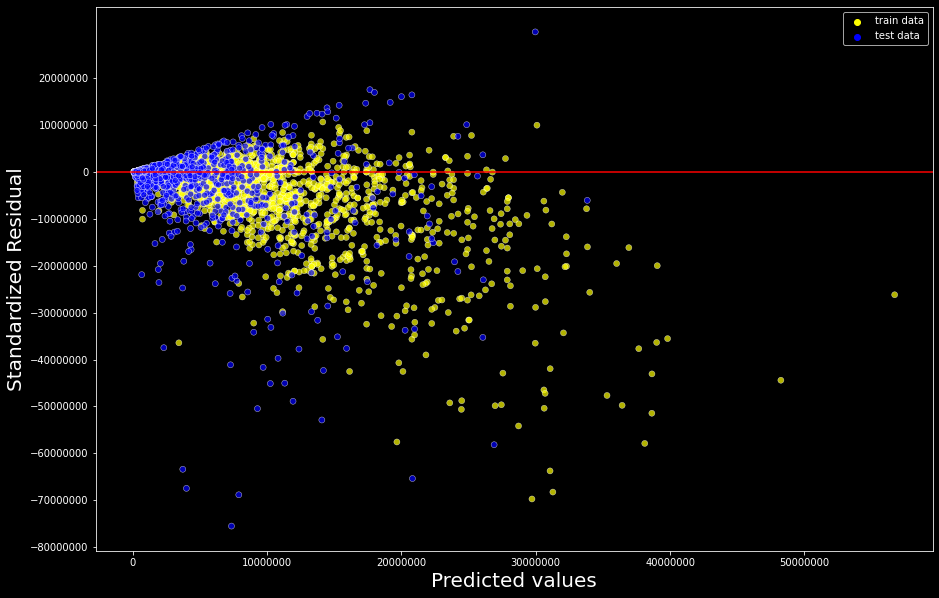

In [83]:
# Plot the relation of actual value and the difference between actual and predicted value
residual_plot(y_test, y_test_pred_ada,'ada_dt_residual_plot', y_train, y_train_pred_ada)